<a href="https://colab.research.google.com/github/arindamroy-eng/Pytorch-and-other-ML-Experiments/blob/main/Pytorch_Custom_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
training_loader = DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

validation_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)





Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach().numpy()
  image = image.squeeze()
  # Swap (1,28,28) to (28, 28, 1)
  image = image.transpose(1,2,0)
  #print(image)
  #normalize. Image data ranges form 0-255. Convert to range -1 to 1
  image = image * np.array((0.5, 0.5,0.5)) + np.array((0.5, 0.5,0.5))
  # limit all the values between 0 and 1
  image = image.clip(0,1)

  return image

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([3, 32, 32]) tensor(9)


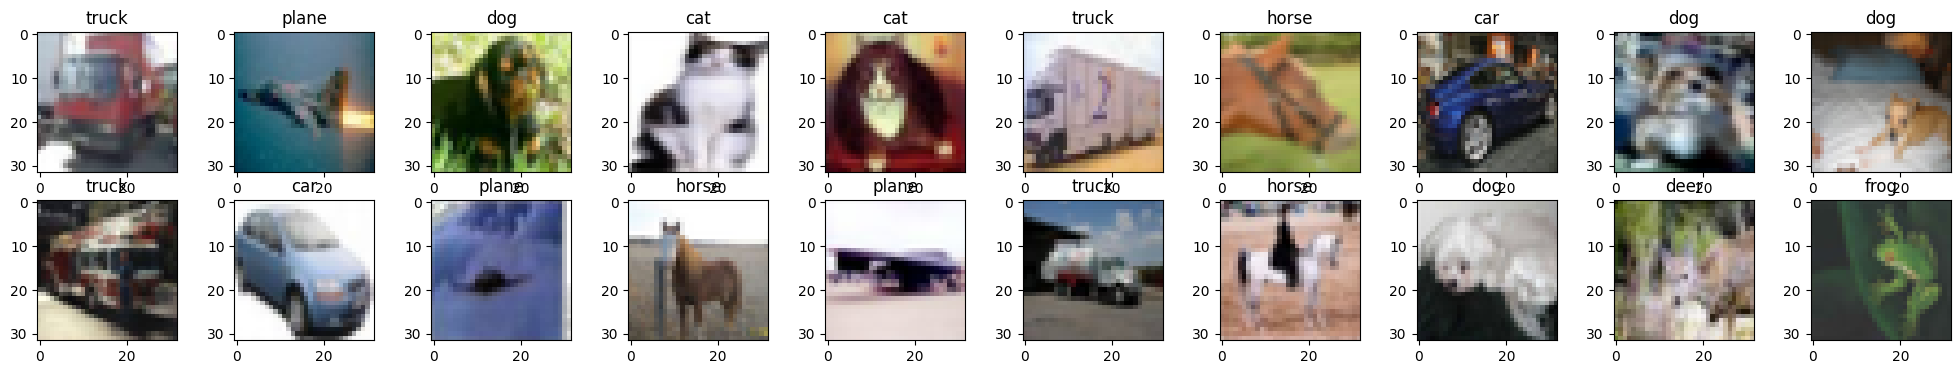

In [ ]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
print(images[0].size(), labels[0])


fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    '''
    # Input size 32x32 per channel. After conv1-> 32-5+1-> 28x28
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1)
    #After maxpool 28x28 becomes 14x14
    self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
    #After conv2 14x14 -> 14-5+1 -> 10x10. After Maxpool it becomes 5x5 with 50 channels
    self.fc1 = nn.Linear(5*5*50, 500)
    '''
    # Increase accuracy by increasing convolution layers.
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    # Now map 500 to 10
    self.fc2 = nn.Linear(500, 10)
  def forward (self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

model = LeNet().to(device)

model


LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_loss_corrects = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # No need to flatten in the next line for CNN
    #inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data).cpu()
    running_loss += loss.item()
  else:
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          #val_inputs = val_inputs.view(inputs.shape[0], -1)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data).cpu()

    epoch_loss = running_loss / len(training_loader)
    epoch_accuracy = running_corrects.float()/len(training_loader)
    running_corrects_history.append(epoch_accuracy)
    running_loss_history.append(epoch_loss)
    #print(f"training loss:{epoch_loss:.4f}, {epoch_accuracy.item():.4f}")
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_accuracy = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_loss_corrects.append(val_epoch_accuracy)

    print(f"Epoch count:{e}")
    print(f"training loss:{epoch_loss:.4f}, accuracy:{epoch_accuracy.item():.4f}")
    print(f"validation loss:{val_epoch_loss:.4f}, accuracy:{val_epoch_accuracy.item():.4f}")


Epoch count:0
training loss:1.0003, accuracy:65.5400
validation loss:0.8153, accuracy:72.5100
Epoch count:1
training loss:0.9138, accuracy:68.1880
validation loss:0.7949, accuracy:73.0500
Epoch count:2
training loss:0.8791, accuracy:69.2900
validation loss:0.7925, accuracy:72.9800
Epoch count:3
training loss:0.8594, accuracy:69.7820
validation loss:0.8051, accuracy:73.2100
Epoch count:4
training loss:0.8442, accuracy:70.4900
validation loss:0.7740, accuracy:73.5400
Epoch count:5
training loss:0.8317, accuracy:70.8860
validation loss:0.7720, accuracy:73.5200
Epoch count:6
training loss:0.8156, accuracy:71.4940
validation loss:0.7511, accuracy:74.6000
Epoch count:7
training loss:0.8038, accuracy:71.8420
validation loss:0.7504, accuracy:75.0000
Epoch count:8
training loss:0.8052, accuracy:71.8700
validation loss:0.7459, accuracy:74.8500
Epoch count:9
training loss:0.7906, accuracy:72.4180
validation loss:0.7674, accuracy:74.0200
Epoch count:10
training loss:0.7813, accuracy:72.4480
valida

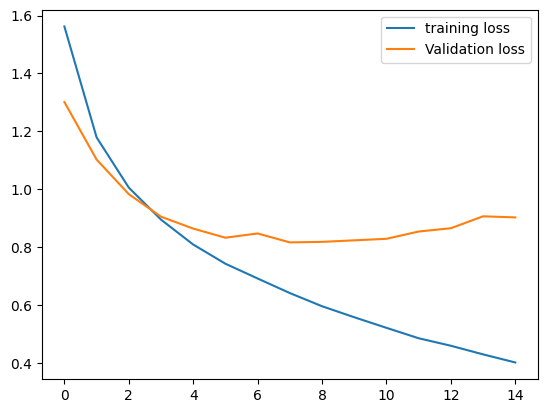

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend()

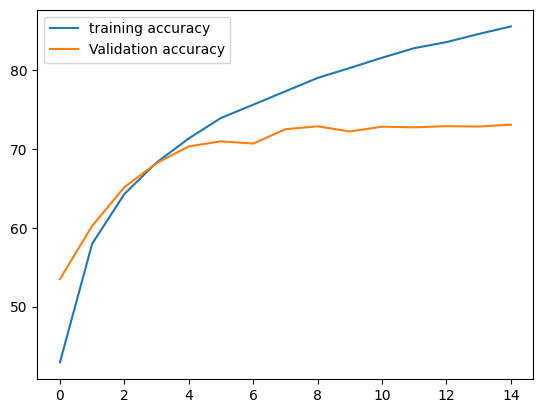

In [ ]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_loss_corrects, label = 'Validation accuracy')
plt.legend()

(400, 271)


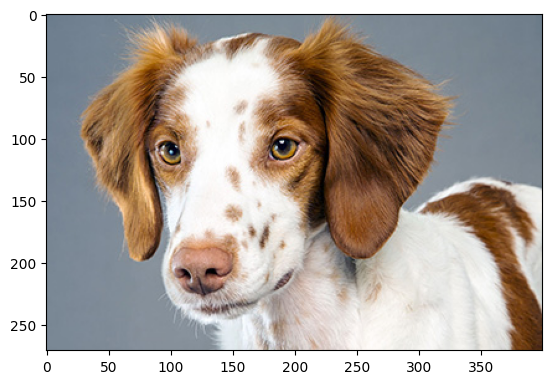

In [ ]:
import requests
from PIL import Image, ImageOps

#url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
#url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Atelopus_zeteki1.jpg/1024px-Atelopus_zeteki1.jpg'
url = 'http://cdn.akc.org/Breeds_Blog_Body_400/Brittany_1.jpg'
response = requests.get(url, stream = True)
#print(response)
img = Image.open(response.raw)
plt.imshow(img)
print(img.size)



torch.Size([3, 32, 32])


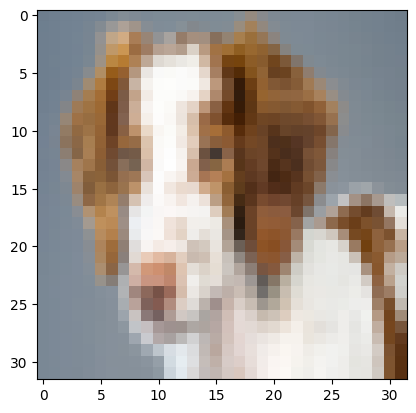

In [ ]:
img = transform(img)
print(img.shape)
plt.imshow(im_convert(img))


In [ ]:
image = img.to(device)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog


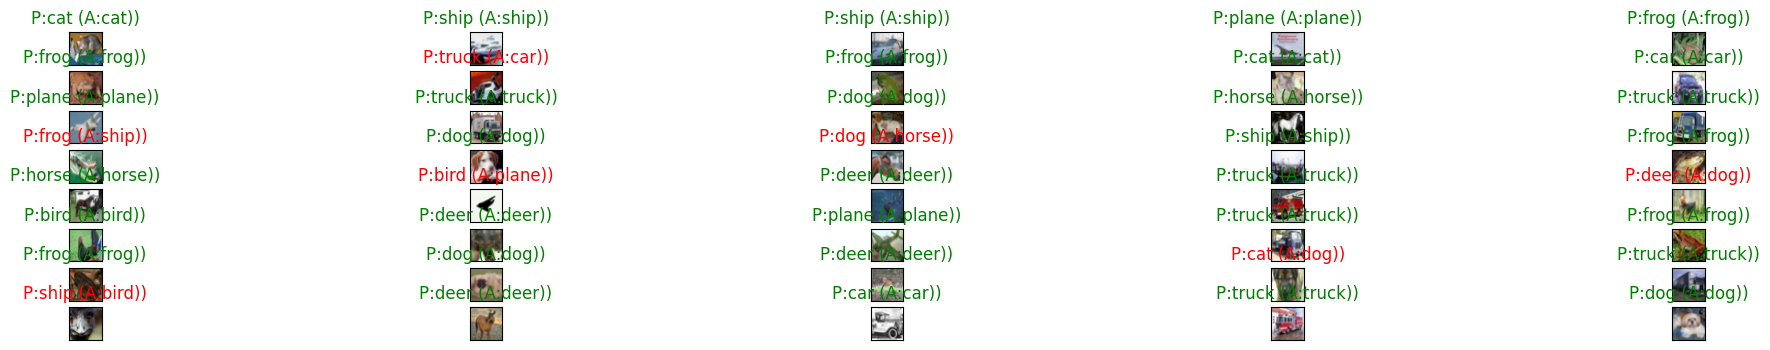

In [ ]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

rows = 8
total = 40
cols = int(total / rows)
for idx in np.arange(total):
  ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("P:{} (A:{}))".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx] == labels[idx] else "red"))


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([500, 1024])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'step': tensor(7500.), 'exp_avg': tensor([[[[ 3.3409e-02,  3.0170e-02,  2.2201e-02],
          [ 2.9526e-02,  2.5827e-02,  1.7961e-02],
          [ 2.3422e-02,  1.7960e-02,  1.0895e-02]],

         [[ 2.8389e-02,  2.4026e-02,  1.6635e-02],
          [ 2.4868e-02,  2.0147e-02,  1.2838e-02],
          [ 2.1372e-02,  1.4807e-02,  8.1682e-03]],

         [[ 3.4024e-02,  2.9425e-02,  2.1389e-02],
          [ 3.3900e-02,  2.7996e-02,  1.8969e-02],
          [ 3.2673e-02,  2.4636e-02,  1.5566e-02]]],


        [[[ 1.2341e-02,  7.4373e-03,  7.1536e-03],
          [ 1.7821e-02,  1.2770e-02,  8.9241e-0